As an expert in lung cancer study.  
I have a dateset with variables of non-small cell lung cancer (NSCL) patients: 
Biomarker (e.i., the biomarker test result of a NSCL patient, including values: "ALK or EGFR", and "other biomarkers"), 
Age (e.i., the age of a NSCL patient, including values: "Young" (<=50) and "Old" (>50)),
Gender (e.i., the gender of a NSCL patient, which is either "Male" or "Female"), 
SmokeType (e.i., the smoking habits of a NSCL patient, which including values: "Never Smoker", "Current Smoker", and "Never Smoker"), 
FamilyCancer (e.i., the cancer type of a NSCL patient's family antecedents with cancer), 
FamilyGender (e.i., the Gender of a NSCL patient's family antecedents with cancer, including values: "Female only", "Male only", and "Female and Male"), 
FamilyDegree (e.i., the family degree of a NSCL patient's family antecedents with cancer, including values: "first degree", "second degree" and "third degree"). 

I want you to give me the reasonable casual relationships among these variables. 
If I miss any confounders of Biomarker in my data, please let me know. 

Instructions:
1. Give the all causal relationships (each is represented as "[A] -> [B]" where [A] and [B] are variables I provide you), your answer should be evidence-backed if you are sure it is causal relationship, e.i., you should provide the title of a real research studies that support your statement. 
2. If you are not sure the causal relationships between two variables, but they are correlated, please reply the "[A] - [B]", your answer should also backed by correct evidences. 
3. Pointing out possible missing confounders of Biomarker in my data. The correct evidences should be given.

# Summarize the data generating process
Now, based on your 

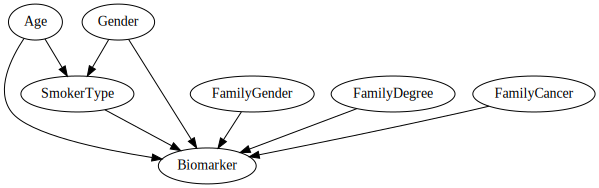

In [25]:
from graphviz import Digraph
# Create Digraph object
dot = Digraph()

# Edges
lung_cancer_edges = [('SmokerType', 'Biomarker'), 
('Age', 'SmokerType'), ('Age', 'Biomarker'), 
('Gender', 'SmokerType'), ('Gender', 'Biomarker'),
('FamilyGender', 'Biomarker'), # ('FamilyGender', 'FamilyCancer'),
('FamilyDegree', 'Biomarker'),
('FamilyCancer', 'Biomarker')]

for head, tail in lung_cancer_edges:
    dot.edge(head, tail)

dot

# Real Data Preparation

In [26]:
import sys , os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from data.data_utils import load_json, unique_values, json2df, create_grouped_stratified_folds


preprocess_json = load_json("../data/category.json")
unique_values(preprocess_json)
df = json2df(preprocess_json, cols=['Age','Gender','SmokerType','Biomarker', 'FamilyCancer', 'FamilyGender', 'FamilyDegree']) # , 'FamilyDiversity'

familycancermap = {"Major": "OnlyMajor", "Minor": "hasMinor", "MajorandMinor": "hasMinor"}
df['FamilyCancer'] = df['FamilyCancer'].apply(lambda x: familycancermap[x])

smokertypemap = {'Never-Smoker': "Non-Smoker", 'Current-Smoker':"Smoker", 'Former-Smoker':"Smoker"}
df['SmokerType'] = df['SmokerType'].apply(lambda x: smokertypemap[x])

# print(df['SmokerType'].value_counts())
# print(df[['Age', 'SmokerType', 'Gender', 'Biomarker']].value_counts())
# calculate_odds_ratios(df=df, y_col='Biomarker', y_value='ALKorEGFR', baseline_dict={"Age": "Young", "Gender": "Female", "SmokerType": "Current-Smoker", 'FamilyCancer':"Minor",
#        'FamilyGender': "Woman", 'FamilyDegree': "Degree1"})


df.to_csv("../data/1808_original.csv", index=False)
df.head()


Age : {'Young', 'Old'}
Gender : {'Male', 'Female'}
SmokerType : {'Never-Smoker', 'Former-Smoker', 'Current-Smoker'}
FamilyCancer : {'Minor', 'Major', 'MajorandMinor'}
Biomarker : {'ALKorEGFR', 'Others'}
FamilyGender : {'Man', 'Woman', 'ManorWoman'}
FamilyDegree : {'Degree2', 'Degree1', 'Degree3'}
FamilyDiversity : {1, 2, 3}


,Age,Gender,SmokerType,Biomarker,FamilyCancer,FamilyGender,FamilyDegree
0,Old,Female,Smoker,Others,OnlyMajor,Man,Degree1
1,Young,Female,Non-Smoker,Others,hasMinor,ManorWoman,Degree3
2,Old,Male,Smoker,Others,OnlyMajor,Man,Degree2
3,Old,Male,Smoker,ALKorEGFR,hasMinor,ManorWoman,Degree1
4,Young,Male,Smoker,Others,hasMinor,Woman,Degree1


/Users/jason/Documents/Coding Projects/KPI3/HealthCareAI Web Semantics/causal/evaluate.py:159: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[column], ax=axes[i], order=ordered_data, palette='viridis')
/Users/jason/Documents/Coding Projects/KPI3/HealthCareAI Web Semantics/causal/evaluate.py:159: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[column], ax=axes[i], order=ordered_data, palette='viridis')
/Users/jason/Documents/Coding Projects/KPI3/HealthCareAI Web Semantics/causal/evaluate.py:159: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn

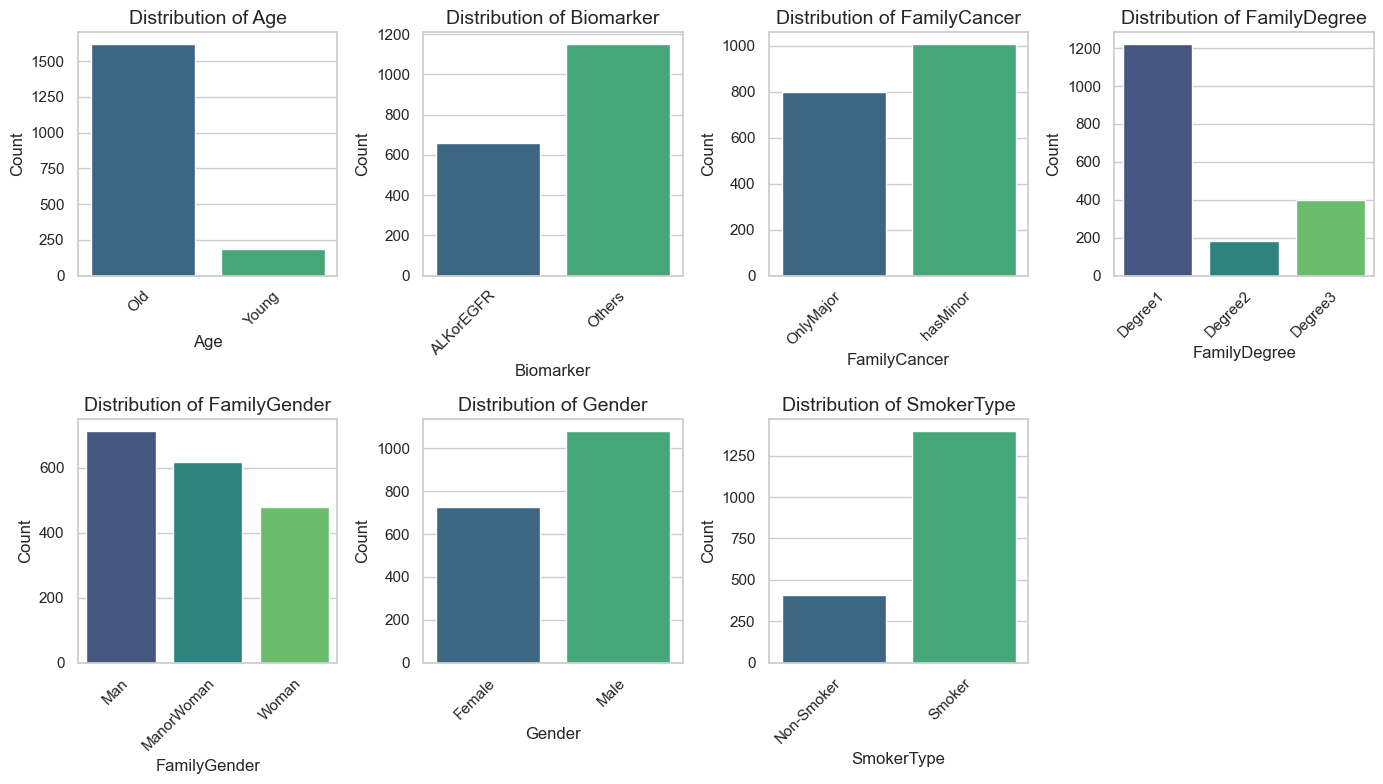

In [27]:
from evaluate import visualize_categorical_distribution
visualize_categorical_distribution(df)

# Causal Data Creation
1. Learn the Addictive Noisy Model (ANM) from the original data
2. Use the ANM generating new data, including T (treatment: SmokerType), Y(outcome: Biomarker), Y0(outcome under intervention of do(T=Non-Smoker)), Y1(outcome under intervention of do(T=Smoker)) and X(covariates: other columns) 

In [28]:
from causal_data_gen import step1, step2, step3, step4, generate_tsv
import numpy as np

np.random.seed(123)
sample_size = 5000

model_M1, model_M2, model_M3 = step1(df)

distributions = step2(df)
generated_data = step3(distributions, num_samples=sample_size, uniform=True)

# print(df['FamilyDegree'])
# df['FamilyDegree'] = df['FamilyDegree'].apply(lambda x: "Degree23" if "2" in x or "3" in x else x)

generated_data_with_outcomes = step4(generated_data, model_M1, model_M2, model_M3)
generated_data_with_outcomes.to_csv(f'../data/{sample_size}_gen.csv', index=False)
generated_data_with_outcomes.head(20)
import pandas as pd
generated_data_with_outcomes = pd.read_csv(f"../data/{sample_size}_gen.csv")

generate_tsv(generated_data_with_outcomes[[c for c in generated_data_with_outcomes.columns if c not in ["Biomarker0","Biomarker1","p_Y1","p_Y0","p_Effect"]]], 
             f"../rule_mining/{sample_size}_rule.tsv")
# visualize_categorical_distribution(generated_data_with_outcomes.drop(columns='Biomarker0,Biomarker1,p_Y1,p_Y0,p_Effect'.split(',')))

             Coefficients      Odds
const           -0.166204  0.846874
Age_Old         -0.128793  0.879156
Gender_Male     -2.042798  0.129665
                         Coefficients      Odds
const                        0.146399  1.157658
FamilyGender_Man             0.067901  1.070259
FamilyGender_ManorWoman     -1.299789  0.272589
                         Coefficients       Odds
const                       -0.268153   0.764790
Age_Old                     -0.727845   0.482949
FamilyCancer_OnlyMajor       0.113781   1.120506
FamilyDegree_Degree2        -0.006436   0.993585
FamilyDegree_Degree3         0.307860   1.360510
FamilyGender_Man            -0.103696   0.901500
FamilyGender_ManorWoman      0.171024   1.186519
Gender_Male                 -0.631556   0.531764
SmokerType_Non-Smoker        2.367979  10.675791


# Causal Graph Learning

In [29]:
import pandas as pd
generated_data_with_outcomes = pd.read_csv(f"../data/{sample_size}_gen.csv")
structure_df = generated_data_with_outcomes.drop(columns=['Biomarker1', 'Biomarker0', 'p_Y1', 'p_Y0', 'p_Effect'])

In [30]:
from bn_library import pc_causal_discovery, fci_causal_discovery, ges_causal_discovery, mmhc 
structures = {} 
structures['PC'] = pc_causal_discovery(structure_df) 


  0%|          | 0/7 [00:00<?, ?it/s]

In [31]:
structures['FCI'] = fci_causal_discovery(structure_df)

  0%|          | 0/7 [00:00<?, ?it/s]

In [32]:
structures['GES'] = ges_causal_discovery(structure_df)

# GPT-4 Causal Relation mining Method 

In [33]:
import networkx as nx

def add_edges_without_cycle(G1_edges, G2_edges):
    # Create directed graph from G1 edges
    G1 = nx.DiGraph()
    G1.add_edges_from(G1_edges)
    
    # Iterate through edges in G2 and try to add them
    for edge in G2_edges:
        G1.add_edge(*edge)  # Add edge temporarily
        if not nx.is_directed_acyclic_graph(G1):
            G1.remove_edge(*edge)  # Remove if it introduces a cycle
    
    # Return the final list of edges in G1 (including valid G2 edges)
    return list(G1.edges)

## GPT4 + without Ontological Knowledge 


\# ROLE \#

Act as an expert on identifying causal relationships between properties within a knowledge graph.

\# CONTEXT \#

You are examining the causal relationships among properties within the knowledge graph.

1. Property: `Biomarker`;

2. Property: `Gender`;

3. Property: `SmokerType`;

4. Property: `Age`;

5. Property: `FamilyCancer`;

6. Property: `FamilyGender`;

7. Property: `FamilyDegree`.

\# OBJECTIVES \#
1. Analyze all these properties in the # CONTEXT # to identify all possible causal relationships among them.
2. Each identified causal relationship should be supported by evidence from academic studies, referenced using title, DOI or PMCID to ensure confidentiality and verify the reliability of the studies.


\# INSTRUCTIONS \#
1. Examine and understand the metadata of each property carefully.
2. Identify all possible causal relationships among the properties in the # CONTEXT #, supported by the title, DOI or PMCID of relevant academic research.
3. Provide, in a code box, the identified causal relationships in the previous step as a Python set of tuples, each with format: ([A], [B]) representing a causal relationship from property [A] to property [B]. 
4. Do not introduce directed loops along the causal relationships.

In [34]:

causal_relationships = [
    ("Age", "Biomarker"),
    ("SmokerType", "Biomarker"),
    ("FamilyCancer", "Biomarker"),
    ("Gender", "Biomarker"),
    ("FamilyDegree", "FamilyCancer"),
    ("FamilyGender", "FamilyCancer")
]

In [35]:
structures['GPT4'] = causal_relationships

## GPT4 + Ontological Knowledge 

\# ROLE \#

Act as an expert in lung cancer research, focusing on identifying causal relationships between properties within a knowledge graph of non-small cell lung cancer (NSCLC) patients.

\# CONTEXT \#

You are examining the causal relationships among properties of `NLCPatient` class, within a knowledge graph, 
with rich metadata that describe their human-understandable label (`rdfs:label`), human-understandable meaning (`rdfs:comment`), domain (`rdfs:domain`), and range (`rdfs:range`):

1. Property: `Biomarker`
   - `rdfs:label`: "biomarker test result"
   - `rdfs:comment`: "The biomarker test results of NSCLC patients, including ALK or EGFR; 'other biomarker' includes MET, HER2, FGFR1, KRAS, RET, PDL1, HER2Mut, ROS1, BRAF."
   - `rdfs:domain`: `NLCPatient`
   - `rdfs:range`: `xsd:string`

2. Property: `Gender`
   - `rdfs:label`: "gender"
   - `rdfs:comment`: "The gender of NSCLC patients, either male or female."
   - `rdfs:domain`: `NLCPatient`
   - `rdfs:range`: `xsd:string`

3. Property: `SmokerType`
   - `rdfs:label`: "smoking habits"
   - `rdfs:comment`: "The smoking habits of NSCLC patients, classified as 'Non-Smoker' or 'Smoker'."
   - `rdfs:domain`: `NLCPatient`
   - `rdfs:range`: `xsd:string`

4. Property: `Age`
   - `rdfs:label`: "age"
   - `rdfs:comment`: "The age of NSCLC patients, classified as 'Young' (<= 50 years) or 'Old' (> 50 years)."
   - `rdfs:domain`: `NLCPatient`
   - `rdfs:range`: `xsd:integer`

5. Property: `FamilyCancer`
   - `rdfs:label`: "family cancer type"
   - `rdfs:comment`: "The type of cancer in the family of NSCLC patients, either 'OnlyMajor' which represents cancer types in {'Breast', 'Lung', 'Colorectal', 'Head and neck', 'Uterus/cervical', 'Esophagogastric', 'Prostate'} or 'hasMinor' which represents other cancer types."
   - `rdfs:domain`: `NLCPatient`
   - `rdfs:range`: `xsd:string`

6. Property: `FamilyGender`
   - `rdfs:label`: "family gender"
   - `rdfs:comment`: "The gender of NSCLC patients' cancered family antecedents, either 'Women', 'Men', or 'WomenorMen'."
   - `rdfs:domain`: `NLCPatient`
   - `rdfs:range`: `xsd:string`

7. Property: `FamilyDegree`
   - `rdfs:label`: "family degree"
   - `rdfs:comment`: "The family degree of NSCLC patients' cancered familial antecedents, classified as 'First degree', 'Second degree', or 'Third degree'."
   - `rdfs:domain`: `NLCPatient`
   - `rdfs:range`: `xsd:string`

Here are rules describing associations among the properties in the knowledge graph:
If a patient has a family history of breast cancer in a female 2nd-degree relative and is a current smoker, they are more likely to have the PDL1 biomarker.
If the patient is male and has a family history of other types of cancer in a male 1st-degree relative, they are more likely to have the PDL1 biomarker.

\# OBJECTIVES \#
1. Analyze all these properties in the # CONTEXT # to identify all possible causal relationships among them.
2. Each identified causal relationship should be supported by evidence from academic studies, referenced using title, DOI or PMCID to ensure confidentiality and verify the reliability of the studies.

\# INSTRUCTIONS \#
1. Examine and understand the metadata of each property and rules of the properties carefully.
2. Identify all possible causal relationships among the properties in the # CONTEXT # based on your understand of the properties, then identify all possible causal relationships  supported by the title, DOI or PMCID of relevant academic research.
3. Provide, in a code box, the identified causal relationships in the previous step as a Python set of tuples, each with format: ([A], [B]) representing a causal relationship from property [A] to property [B]. 
4. Do not introduce directed loops along the causal relationships.	

In [36]:
# https://chatgpt.com/share/042f110c-197d-4f71-86f9-ab54de46a831 

causal_relationships = [
    ('SmokerType', 'Biomarker'),
    ('FamilyCancer', 'Biomarker'),
    ('FamilyGender', 'Biomarker'),
    ('FamilyDegree', 'Biomarker'),
    ('Gender', 'Biomarker')
]
structures['GPT4+Domain'] = causal_relationships



In [37]:
# structures['Hybrid(GPT4)'] = list(set(structures['GPT4'] + structures['PC']))
structures['Hybrid(Baseline2+PC)'] = list(set(add_edges_without_cycle(structures['GPT4'], structures['PC'])))

In [38]:
# structures['Hybrid(GPT4+Domain)'] = list(set(structures['GPT4+Domain'] + structures['PC']))
structures['Hybrid(Baseline3+PC)'] = list(set(add_edges_without_cycle(structures['GPT4+Domain'], structures['PC'])))

# Expert

In [39]:
structures['Expert'] = [('SmokerType', 'Biomarker'), 
('Age', 'SmokerType'), ('Age', 'Biomarker'), 
('Gender', 'SmokerType'), ('Gender', 'Biomarker'),
('FamilyGender', 'Biomarker'), # ('FamilyGender', 'FamilyCancer'),
('FamilyDegree', 'Biomarker'),
('FamilyCancer', 'Biomarker')]

In [40]:
import pickle
with open(f"structures_{sample_size}.pkl", 'wb') as f:
    pickle.dump(structures, f)
for k, g in structures.items():
    print(k, ":", g)

PC : [('Age', 'Biomarker'), ('Gender', 'SmokerType'), ('Gender', 'Biomarker'), ('FamilyGender', 'Biomarker'), ('FamilyDegree', 'Biomarker'), ('SmokerType', 'Biomarker')]
FCI : [('Age', 'Biomarker'), ('Gender', 'SmokerType'), ('Gender', 'Biomarker'), ('FamilyGender', 'Biomarker'), ('FamilyDegree', 'Biomarker'), ('SmokerType', 'Biomarker')]
GES : [('Age', 'Biomarker'), ('Gender', 'SmokerType'), ('Gender', 'Biomarker'), ('FamilyDegree', 'Biomarker'), ('SmokerType', 'Biomarker')]
GPT4 : [('Age', 'Biomarker'), ('SmokerType', 'Biomarker'), ('FamilyCancer', 'Biomarker'), ('Gender', 'Biomarker'), ('FamilyDegree', 'FamilyCancer'), ('FamilyGender', 'FamilyCancer')]
GPT4+Domain : [('SmokerType', 'Biomarker'), ('FamilyCancer', 'Biomarker'), ('FamilyGender', 'Biomarker'), ('FamilyDegree', 'Biomarker'), ('Gender', 'Biomarker')]
Hybrid(Baseline2+PC) : [('Gender', 'Biomarker'), ('FamilyGender', 'FamilyCancer'), ('FamilyGender', 'Biomarker'), ('FamilyDegree', 'FamilyCancer'), ('SmokerType', 'Biomarker'

In [41]:
def format_latex_table(df):
    # Convert the DataFrame to a LaTeX table
    return df.to_latex(index=False, float_format="%.3f", column_format="lcccc")

method_results = []
gold_standard = set(structures['Expert'])
for method, predictions in structures.items():
    if method == 'Expert' :
        continue
    predictions = set(predictions)
    predictions_set = set(predictions)
    intersection = gold_standard.intersection(predictions_set)
    union = gold_standard.union(predictions_set)
    
    jaccard_index = len(intersection) / len(union) if union else 0
    precision = len(intersection) / len(predictions_set) 
    recall = len(intersection) / len(gold_standard)
    F1 = 2 * (precision * recall) / (precision + recall) if precision + recall else 0
    method_results.append({
        'Method': method,
        'Jaccard Index': jaccard_index,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': F1
    })

print(format_latex_table(pd.DataFrame(method_results)))

\begin{tabular}{lcccc}
\toprule
Method & Jaccard Index & Precision & Recall & F1-Score \\
\midrule
PC & 0.750 & 1.000 & 0.750 & 0.857 \\
FCI & 0.750 & 1.000 & 0.750 & 0.857 \\
GES & 0.625 & 1.000 & 0.625 & 0.769 \\
GPT4 & 0.400 & 0.667 & 0.500 & 0.571 \\
GPT4+Domain & 0.625 & 1.000 & 0.625 & 0.769 \\
Hybrid(Baseline2+PC) & 0.700 & 0.778 & 0.875 & 0.824 \\
Hybrid(Baseline3+PC) & 0.875 & 1.000 & 0.875 & 0.933 \\
\bottomrule
\end{tabular}



In [42]:
pd.DataFrame(method_results)  

,Method,Jaccard Index,Precision,Recall,F1-Score
0,PC,0.750,1.000000,0.750,0.857143
1,FCI,0.750,1.000000,0.750,0.857143
2,GES,0.625,1.000000,0.625,0.769231
3,GPT4,0.400,0.666667,0.500,0.571429
4,GPT4+Domain,0.625,1.000000,0.625,0.769231
5,Hybrid(Baseline2+PC),0.700,0.777778,0.875,0.823529
6,Hybrid(Baseline3+PC),0.875,1.000000,0.875,0.933333


# Visualization

In [43]:
def show_graph(edges):
    from graphviz import Digraph
    # Create Digraph object
    dot = Digraph()
    # G = []
    for A, B in edges:
        dot.edge(A, B)
    return dot

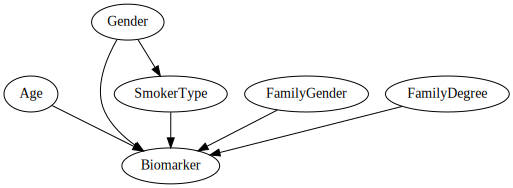

In [44]:
show_graph(structures['PC'])

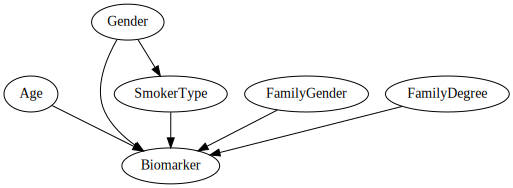

In [45]:
show_graph(structures['FCI'])

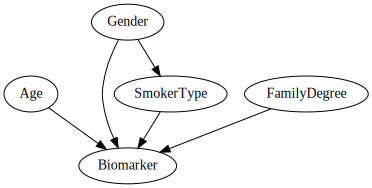

In [46]:
show_graph(structures['GES'])

In [47]:
show_graph(structures['GPT4+Ontology'])

KeyError: 'GPT4+Ontology'

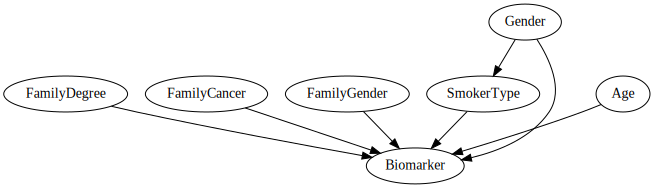

In [ ]:
show_graph(structures['Hybrid']) 

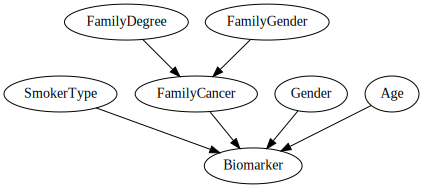

In [ ]:
show_graph(structures['GPT4'])